In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
import scipy.spatial
import pickle

jax.config.update("jax_platform_name", "gpu")
import confirm.mini_imprint.lewis_drivers as lts
from confirm.mini_imprint import grid
import adastate
import diagnostics

In [2]:
from confirm.lewislib import lewis, batch

name = "4d_full"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}
lei_obj = lewis.Lewis45(**params)

In [3]:
with open(f"./{name}/data_params.pkl", "rb") as f:
    P, D = pickle.load(f)
load_iter = "latest"
S, load_iter, fn = adastate.load(name, load_iter)

loading checkpoint 4d_full/3880.pkl


In [6]:
with open(f"./{name}/storage_0.075.pkl", "rb") as f:
    S_load = pickle.load(f)

In [7]:
S = adastate.AdaState(
    grid.concat_grids(S.g, S_load.g),
    np.concatenate((S.sim_sizes, S_load.sim_sizes), dtype=np.int32),
    np.concatenate((S.todo, S_load.todo), dtype=bool),
    adastate.TileDB(
        np.concatenate((S.db.data, S_load.db.data), dtype=np.float32), S.db.slices
    ),
)

In [10]:
overall_lam = S.orig_lam.min()

In [11]:
worst_tile_idx = np.argmin(S.orig_lam)
worst_tile = S.g.theta_tiles[worst_tile_idx]

## Tile density

In [10]:
plot_dims = [2, 3]
slc = diagnostics.build_2d_slice(S.g, worst_tile, plot_dims)

In [11]:
theta_tiles2 = S.g.theta_tiles.copy()
theta_tiles2[:, 2] = S.g.theta_tiles[:, 3]
theta_tiles2[:, 3] = S.g.theta_tiles[:, 2]
sym_tiles1 = np.concatenate((S.g.theta_tiles, theta_tiles2))

theta_tiles3 = sym_tiles1.copy()
theta_tiles3[:, 1] = sym_tiles1[:, 2]
theta_tiles3[:, 2] = sym_tiles1[:, 1]
all_tiles = np.concatenate((sym_tiles1, theta_tiles3))

In [12]:
all_lam = np.concatenate((S.orig_lam, S.orig_lam, S.orig_lam, S.orig_lam))

In [13]:
tree = scipy.spatial.KDTree(all_tiles)

In [14]:
nearby = tree.query_ball_point(slc.reshape((-1, 4)), 0.04)
nearby_count = [len(n) for n in nearby]

In [15]:
dist1, idx1 = tree.query(slc.reshape((-1, 4)), k=1)

In [16]:
dist, idx = tree.query(slc.reshape((-1, 4)), k=10)

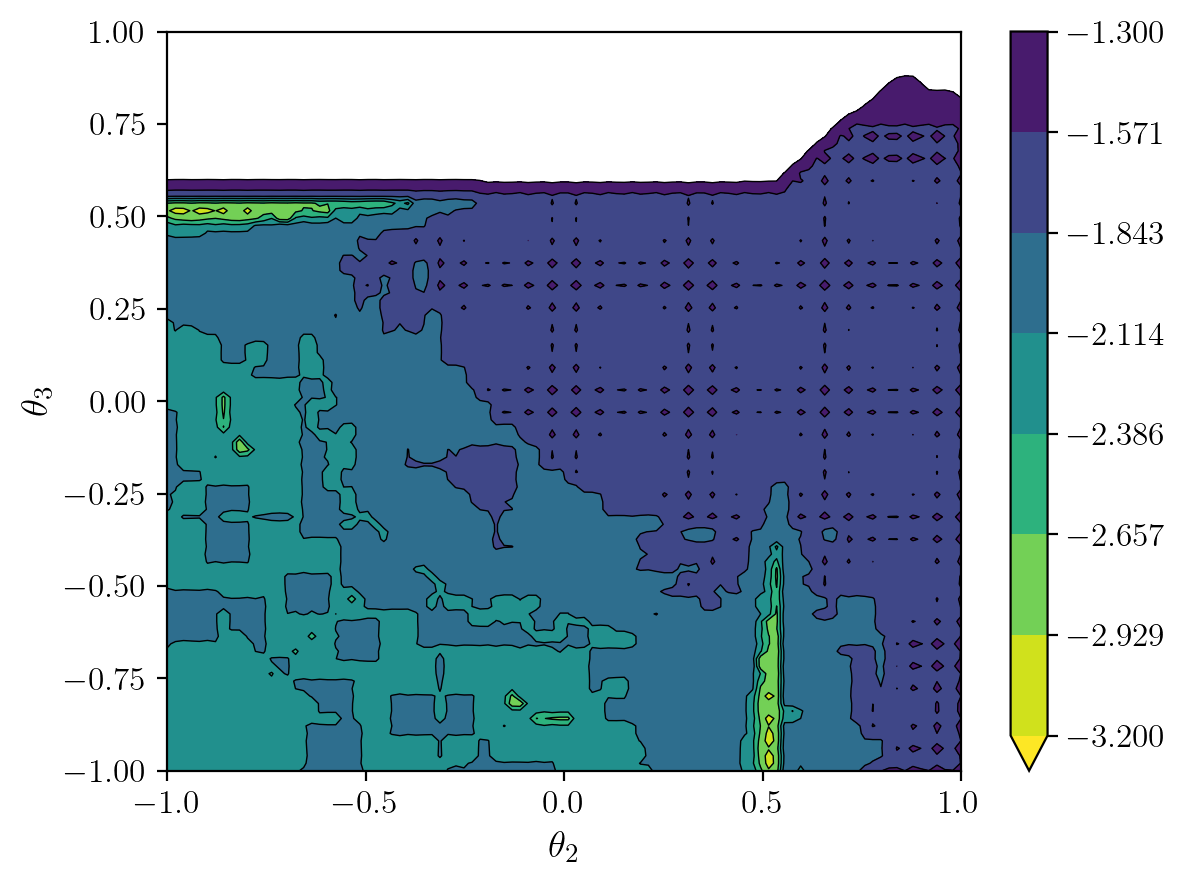

In [17]:
x = slc[..., plot_dims[0]]
y = slc[..., plot_dims[1]]
z = dist.mean(axis=1).reshape(slc.shape[:2])
z = np.log10(z)
levels = np.linspace(-3.2, -1.3, 8)
cntf = plt.contourf(x, y, z, levels=levels, cmap="viridis_r", extend="min")
plt.contour(
    x, y, z, levels=levels, colors="k", linestyles="-", linewidths=0.5, extend="min"
)
cbar = plt.colorbar(cntf)
plt.xlabel(f"$\\theta_{plot_dims[0]}$")
plt.ylabel(f"$\\theta_{plot_dims[1]}$")
plt.show()

/tmp/ipykernel_19438/616776376.py:5: RuntimeWarning: divide by zero encountered in log10
  z = np.log10(z)


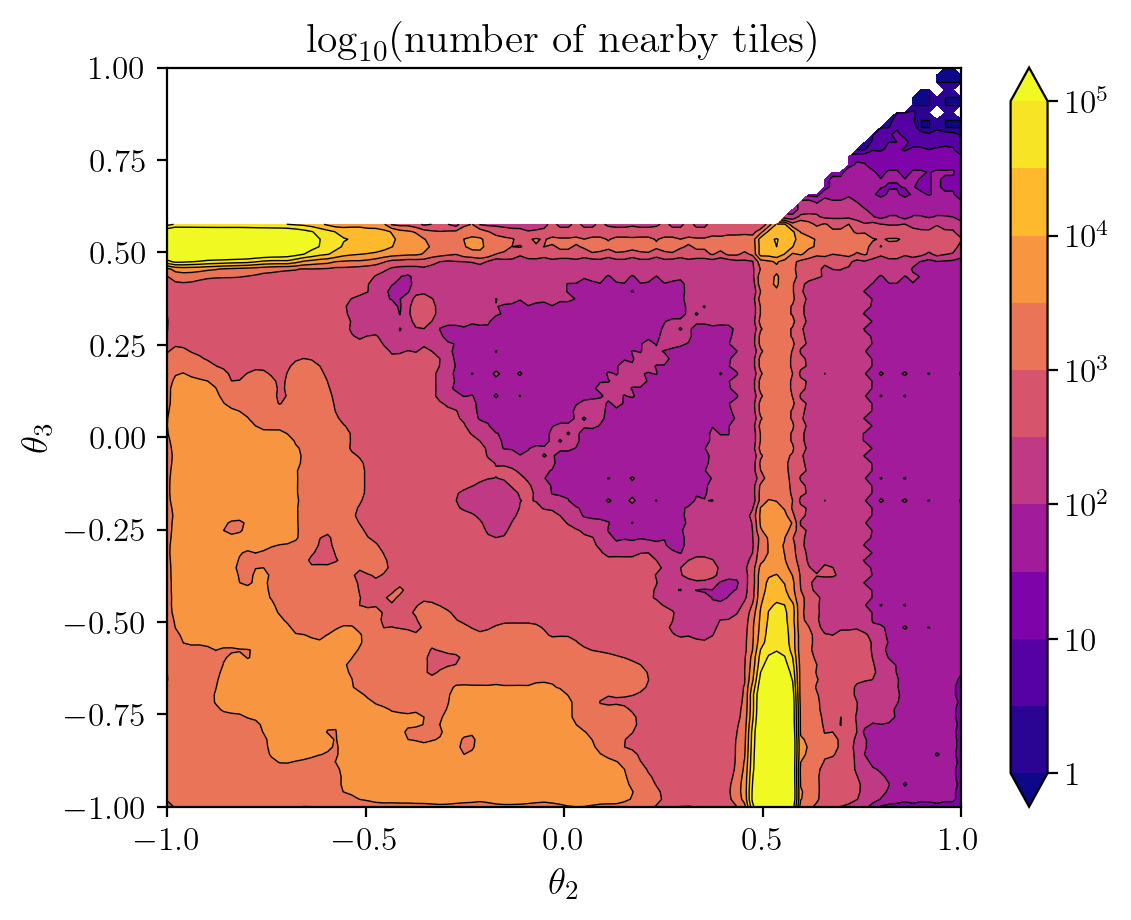

In [18]:
x = slc[..., plot_dims[0]]
y = slc[..., plot_dims[1]]
z = np.array(nearby_count).reshape(slc.shape[:2])
# z[z == 0] = z.T[z == 0]
z = np.log10(z)
levels = np.linspace(0, 5, 11)
plt.title("$\log_{10}$(number of nearby tiles)")
cntf = plt.contourf(x, y, z, levels=levels, extend="both")
plt.contour(
    x,
    y,
    z,
    levels=levels,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    extend="both",
)
cbar = plt.colorbar(cntf, ticks=np.arange(6))
cbar.ax.set_yticklabels(["1", "10", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
plt.xlabel(f"$\\theta_{plot_dims[0]}$")
plt.ylabel(f"$\\theta_{plot_dims[1]}$")
plt.show()

## Type I error calculate

In [ ]:
import confirm.mini_imprint.lewis_drivers as ld

In [12]:
plot_dims = [2, 3]
slc = diagnostics.build_2d_slice(S.g, worst_tile, plot_dims)
slc_ravel = slc.reshape((-1, S.g.d))
nx, ny, _ = slc.shape
eval_pts = slc.reshape((-1, 4))
null_truth = np.array([eval_pts.dot(H.n) - H.c >= 0 for H in S.g.null_hypos]).T

In [15]:
K = 32768
K * eval_pts.shape[0] * 5e-7

163.84

In [16]:
# typeI_sum = ld.rej_runner(
#     lei_obj,
#     np.full(eval_pts.shape[0], K),
#     overall_lam,
#     eval_pts,
#     null_truth,
#     D.unifs,
#     D.unifs_order,
# )
with open("4d_full/plot.pkl", "rb") as f:
    slc_load, typeI_sum = pickle.load(f)

In [17]:
np.testing.assert_allclose(slc, slc_load)

In [18]:
with open("4d_full/plot.pkl", "wb") as f:
    pickle.dump((slc, typeI_sum), f)

In [29]:
typeI_err = typeI_sum / K
typeI_err[np.all(~null_truth, axis=1)] = np.nan
import confirm.mini_imprint.binomial as binomial

delta = 0.01
typeI_err, typeI_CI = binomial.zero_order_bound(typeI_sum, K, delta, 1.0)
typeI_bound = typeI_err + typeI_CI

In [30]:
import confirm.mini_imprint.bound.binomial as tiltbound

n_arm_samples = lei_obj.n_arm_samples
theta0 = eval_pts
v = eval_pts - theta0

In [31]:
fwd_solver = tiltbound.ForwardQCPSolver(n=lei_obj.n_arm_samples)


def forward_bound(theta0, vertices, f0):
    v = vertices - theta0
    q_opt = fwd_solver.solve(theta0, v, f0)
    return tiltbound.tilt_bound_fwd_tile(q_opt, n_arm_samples, theta0, v, f0)


bound = jax.jit(jax.vmap(forward_bound))(theta0, eval_pts, typeI_bound)

In [32]:
# step 1: evaluate the field of interest. if it's lambda*, we already have what
# we need. if it's TIE, we need to calculate it for the relevant tiles.

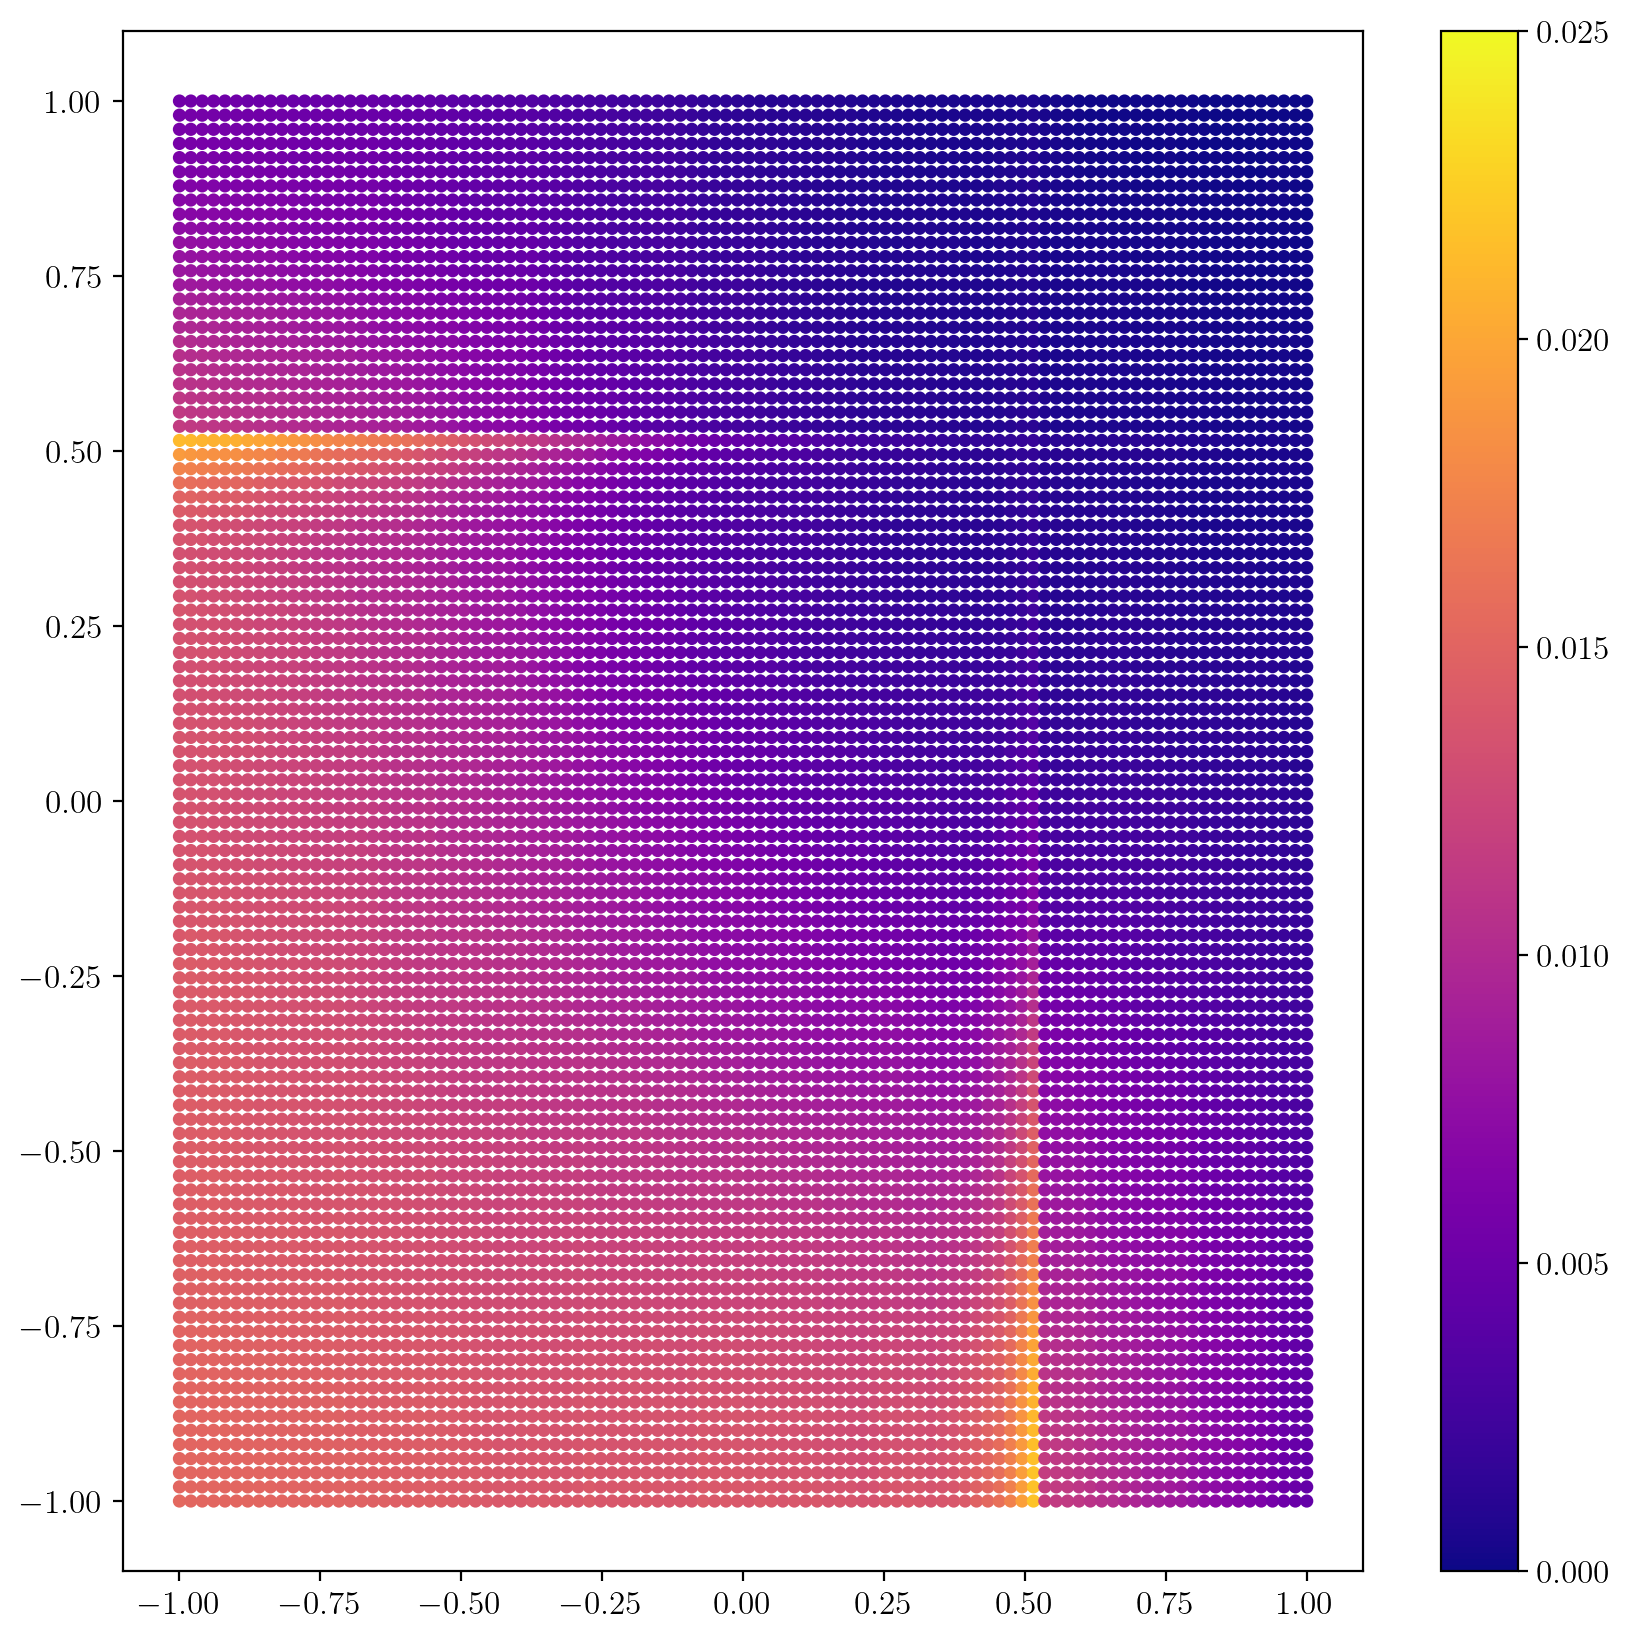

In [33]:
slc1d = slc.reshape((-1, 4))
plt.figure(figsize=(10, 10))
plt.scatter(
    slc1d[:, plot_dims[0]],
    slc1d[:, plot_dims[1]],
    c=typeI_err,
    vmin=0,
    vmax=0.025,
    s=14,
)
plt.colorbar()
plt.show()

In [38]:
worst_tile

array([ 0.53271484,  0.53271484,  0.53271484, -0.99951172])

In [45]:
unplot_dims = list(set(range(S.g.d)) - set(plot_dims))

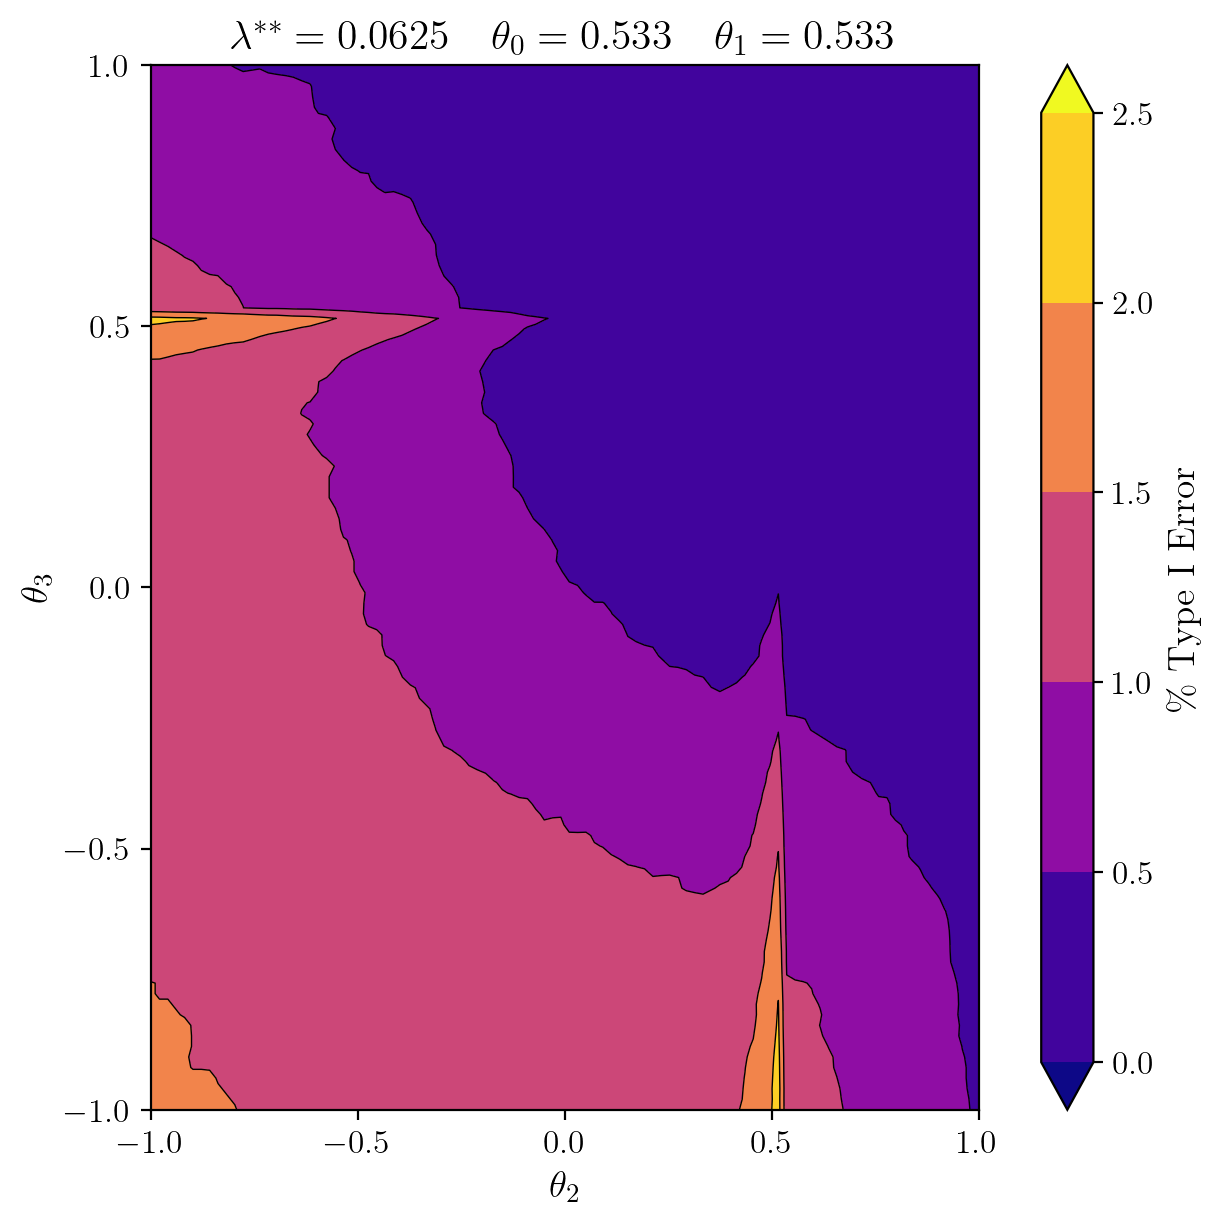

In [55]:
x = slc[..., plot_dims[0]]
y = slc[..., plot_dims[1]]
z = typeI_err.reshape(slc.shape[:2])
plt.figure(figsize=(6, 6), constrained_layout=True)
lam_str = "\lambda^{**}" + f" = {overall_lam:.4f}"
up0_str = f"\\theta_{unplot_dims[0]} = {slc[0,0,unplot_dims[0]]:.3f}"
up1_str = f"\\theta_{unplot_dims[1]} = {slc[0,0,unplot_dims[1]]:.3f}"
plt.title(f"${lam_str} ~~~ {up0_str} ~~~ {up1_str}$")
levels = np.linspace(0, 2.5, 6)
cbar_target = plt.contourf(x, y, z * 100, levels=levels, extend="both")
plt.contour(
    x,
    y,
    z * 100,
    levels=levels,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    extend="both",
)
cbar = plt.colorbar(cbar_target)
cbar.set_label("\% Type I Error")
# plt.axvline(x=0, color="k", linestyle="-", linewidth=4)
# plt.axhline(y=0, color="k", linestyle="-", linewidth=4)
plt.xlabel(f"$\\theta_{plot_dims[0]}$")
plt.xticks(np.linspace(-1, 1, 5))
plt.ylabel(f"$\\theta_{plot_dims[1]}$")
plt.yticks(np.linspace(-1, 1, 5))
plt.show()

In [61]:
# lamstar = ld.bootstrap_tune_runner(
#     lei_obj,
#     np.full(eval_pts.shape[0], 2**16),
#     np.full(eval_pts.shape[0], 0.025),
#     eval_pts,
#     null_truth,
#     D.unifs,
#     D.bootstrap_idxs,
#     D.unifs_order,
# )
with open("4d_full/plot_lamstar.pkl", "rb") as f:
    slc_load, lamstar = pickle.load(f)

simulating with K=65536 and n_tiles=10000 and batch_size=(64, 1024)
simulation runtime 644.8696477413177


In [75]:
with open("4d_full/plot_lamstar.pkl", "wb") as f:
    pickle.dump((slc, lamstar), f)

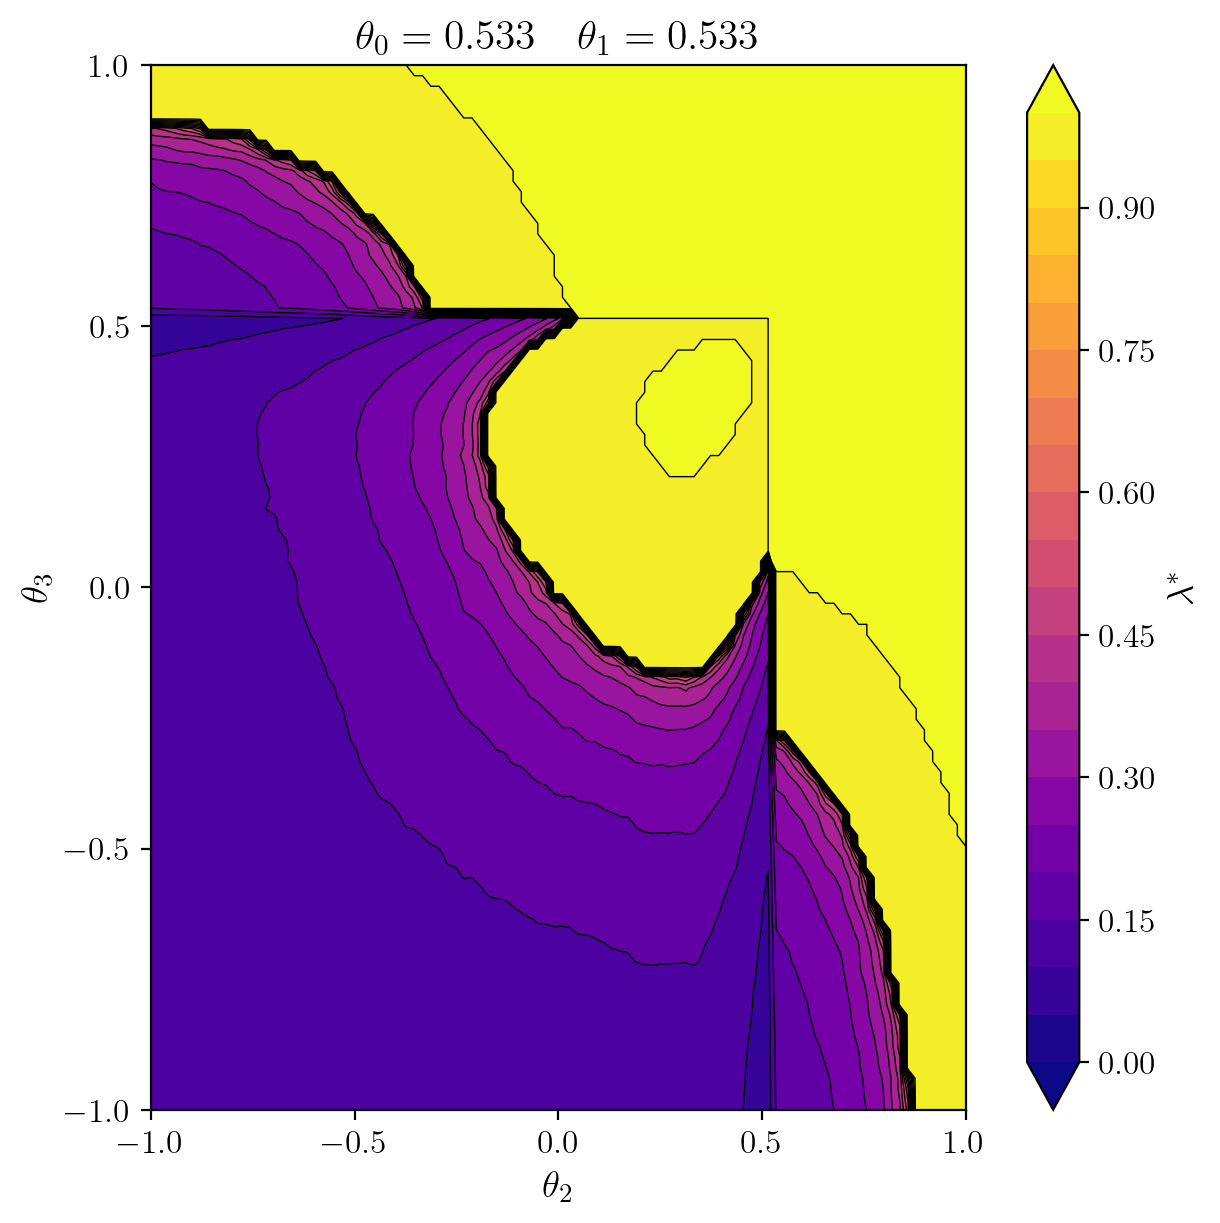

In [69]:
x = slc[..., plot_dims[0]]
y = slc[..., plot_dims[1]]
z = lamstar[:, 0].reshape(slc.shape[:2])
plt.figure(figsize=(6, 6), constrained_layout=True)
up0_str = f"\\theta_{unplot_dims[0]} = {slc[0,0,unplot_dims[0]]:.3f}"
up1_str = f"\\theta_{unplot_dims[1]} = {slc[0,0,unplot_dims[1]]:.3f}"
plt.title(f"${up0_str} ~~~ {up1_str}$")
levels = np.linspace(0, 1.0, 21)
cbar_target = plt.contourf(x, y, z, levels=levels, extend="both")
plt.contour(
    x,
    y,
    z,
    levels=levels,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    extend="both",
)
cbar = plt.colorbar(cbar_target)
cbar.set_label("$\lambda^*$")
# plt.axvline(x=0, color="k", linestyle="-", linewidth=4)
# plt.axhline(y=0, color="k", linestyle="-", linewidth=4)
plt.xlabel(f"$\\theta_{plot_dims[0]}$")
plt.xticks(np.linspace(-1, 1, 5))
plt.ylabel(f"$\\theta_{plot_dims[1]}$")
plt.yticks(np.linspace(-1, 1, 5))
plt.show()

In [73]:
lamstar[:, :1].min()

0.0731595619096452

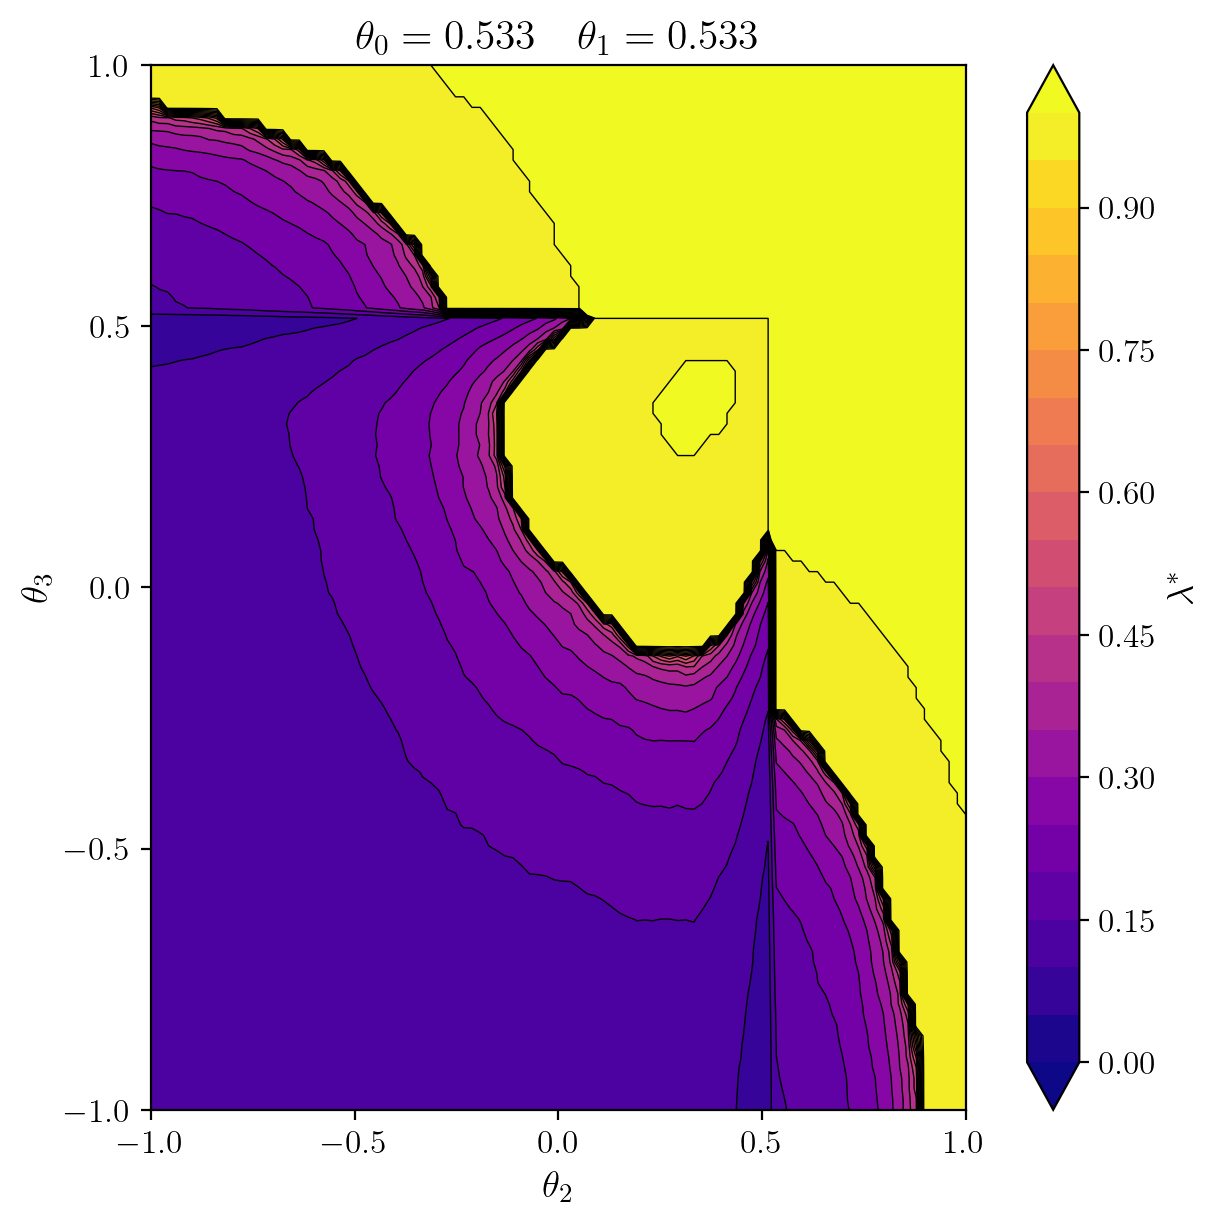

In [70]:
x = slc[..., plot_dims[0]]
y = slc[..., plot_dims[1]]
z = lamstar[:, 1:51].min(axis=1).reshape(slc.shape[:2])
plt.figure(figsize=(6, 6), constrained_layout=True)
up0_str = f"\\theta_{unplot_dims[0]} = {slc[0,0,unplot_dims[0]]:.3f}"
up1_str = f"\\theta_{unplot_dims[1]} = {slc[0,0,unplot_dims[1]]:.3f}"
plt.title(f"${up0_str} ~~~ {up1_str}$")
levels = np.linspace(0, 1.0, 21)
cbar_target = plt.contourf(x, y, z, levels=levels, extend="both")
plt.contour(
    x,
    y,
    z,
    levels=levels,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    extend="both",
)
cbar = plt.colorbar(cbar_target)
cbar.set_label("$\lambda^*$")
# plt.axvline(x=0, color="k", linestyle="-", linewidth=4)
# plt.axhline(y=0, color="k", linestyle="-", linewidth=4)
plt.xlabel(f"$\\theta_{plot_dims[0]}$")
plt.xticks(np.linspace(-1, 1, 5))
plt.ylabel(f"$\\theta_{plot_dims[1]}$")
plt.yticks(np.linspace(-1, 1, 5))
plt.show()